In [15]:
import os
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import pims
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imsave
from skimage.measure import regionprops
import trackpy as tp
from scipy.signal import spectrogram, periodogram,savgol_filter
from scipy.signal import find_peaks
import pg_analysis.plotter as pga
import pg_analysis
from scipy.stats import skew
from scipy.signal import find_peaks
import re
from pg_analysis import style
#plt.style.use('~/Code/AnalysisNotebooksMKS/NIFStyle.mplstyle')
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.get_cmap('tab10').colors)

# This script is for P. Pacificus and C.elegans predatory recordings using the dual view

## Define units

In [2]:
units = {'x': 'cm',
 'y': 'cm',
 'frame': 1,
 'pumps': 'a.f.u.',
 'signal_mean': 'a.f.u.',
         'signal_max': 'a.f.u.',
 "velocity":"um/s",
 'Istd': 'a.f.u.',
 'Centerline': '1',
 'Straightened': 1,
 'area': 'px^2',
 'temperature': 'C',
 'humidity': '%',
 "reversals_nose":1,
 "reversal_events_nose":1,
 'size': 'mm',
 'age': 'h',
 '@acclimation': 'min',
'Imean':'a.f.u'}

## Define path

In [16]:
path = '/gpfs/soma_fs/home/ramahefarivo/nif/Euphrasie2/test_script/Predationresults/'
outpath = '/gpfs/soma_fs/home/ramahefarivo/nif/Euphrasie2/test_script/Predationresults/'

# here are raw tracking coordinate files
raw_data_path = '/gpfs/soma_fs/home/ramahefarivo/nif9201/1_rawdata_tracking/Projects/Macroscope_paper/Ppa_XE1995_Predatory_assay/Bite'
folders = ['ER_Predation_64']

## pga.Experiment 

In [17]:
# Initialize experiment
control = pga.Experiment(strain='Ppa', condition='On larvae', scale=1.58, fps=30)
control.load_data('/', units=units)

# Process each folder
for fidx, folder in enumerate(folders[0:1]):
    fpath = Path(raw_data_path) / Path(folder)
    print(f"Processing folder: {fpath}")

    # Load coordinate file
    coords = list(filter(Path.is_file, fpath.glob('*.txt')))
    if not coords:
        raise FileNotFoundError(f"No coordinate files found in {fpath}")
    tracks_path = coords[-1]
    tracks = pd.read_csv(
        tracks_path, delim_whitespace=True, skiprows=28, comment='#',
        names=["Frame", "Time", "X", "Y", "Z"], engine="python"
    )
    print(f"Successfully read tracks from {tracks_path}. Shape: {tracks.shape}")

    # Load signals
    signals_path = f"{path}{folder}_signals.json"
    print(f"Loading signals from: {signals_path}")
    data = pd.read_json(signals_path, orient='split')
    data = data.drop(['Straightened', 'StraightKymo', 'mask'], axis=1, errors='ignore')

    # Interpolate missing frames in signal data
    old_frames = data['frame'].copy().values
    idx = pd.Index(np.arange(data['frame'].min(), data['frame'].max() + 1), name="frame")
    data = data.set_index("frame").reindex(idx).reset_index()
    data = data.interpolate()

    # Load centerline data (already in correct orientation and units)
    centerline_path = f"{path}{folder}_um_centerlines.csv"
    centerline = pd.read_csv(centerline_path, header=None).to_numpy()
    centerline = np.reshape(centerline, (centerline.shape[0], centerline.shape[1] // 2, 2))

    # Scale track coordinates to micrometers
    tracks["X"] *= 1000  # Convert to µm
    tracks["Y"] *= 1000

    # Interpolate missing frames in tracks
    idx = pd.Index(np.arange(tracks["Frame"].min(), tracks["Frame"].max() + 1), name="Frame")
    tracks = tracks.set_index("Frame").reindex(idx).reset_index()
    tracks = tracks.interpolate()

    # Merge track and signal data
    tracks = pd.merge(tracks, data, left_index=True, right_index=True)

    # Interpolate centerline to match track length (no rotation needed)
    df_x = pd.DataFrame(centerline[:, :, 0], index=old_frames)
    df_x = df_x.reindex(np.arange(np.min(old_frames), np.max(old_frames) + 1))
    df_x.interpolate(method='linear', inplace=True)
    df_y = pd.DataFrame(centerline[:, :, 1], index=old_frames)
    df_y = df_y.reindex(np.arange(np.min(old_frames), np.max(old_frames) + 1))
    df_y.interpolate(method='linear', inplace=True)
    centerline = np.stack([df_x.values, df_y.values], axis=2)

    # Rename columns for consistency
    names = {"Frame": "frame", "X": "x", "Y": "y", "Z": "z"}
    tracks.rename(columns=names, inplace=True)

    # Add to pga.Worm object
    w = pga.Worm(
        '', columns=None, fps=control.fps, scale=control.scale, units=units,
        particle_index=fidx, load=False
    )
    w.data = tracks.reset_index()
    w.data = w.data.loc[:, ~w.data.columns.duplicated()].copy()
    w.centerline = centerline
    control.samples.append(w)

Processing folder: /gpfs/soma_fs/home/ramahefarivo/nif9201/1_rawdata_tracking/Projects/Macroscope_paper/Ppa_XE1995_Predatory_assay/Bite/ER_Predation_64
Successfully read tracks from /gpfs/soma_fs/home/ramahefarivo/nif9201/1_rawdata_tracking/Projects/Macroscope_paper/Ppa_XE1995_Predatory_assay/Bite/ER_Predation_64/2025-02-28-15-16-22-722028-coords.txt. Shape: (8286, 5)
Loading signals from: /gpfs/soma_fs/home/ramahefarivo/nif/Euphrasie2/test_script/Predationresults/ER_Predation_64_signals.json


## Calculate and add 'negskew' and negskew_clean 

In [18]:
def add_negskew_column(samples): # negskew from data directly after ini macro_analysis.py script
    for w in samples:
        try:
            # Add 'negskew' column to worm's data
            w.add_column(key='negskew', values=-1 * w.data['skew'], overwrite=True)
            
            # Verify if the new column is added
            df = w.data
            print("df columns after adding negskew:", df.columns)
            
        except Exception as e:
            print(f"Error processing worm {w}: {e}")


add_negskew_column(control.samples)

df columns after adding negskew: Index(['index', 'frame', 'Time_x', 'x', 'y', 'z', 'Time_y', 'Xstage', 'Ystage',
       'Xworm', 'Yworm', 'signal_max', 'signal_mean', 'cms_y', 'cms_x', 'skew',
       'time', 'negskew'],
      dtype='object')


In [19]:
def smooth_signal_and_detect_peaks(samples):
    for w in samples:
        try:
            # Access raw negskew signal directly
            signal = w.data['negskew']
            
            # Keep the background subtraction but remove the smoothing
            window_size = 30  # For background estimation only
            bg_smooth = signal.rolling(window_size, min_periods=1, center=True).mean()
            signal_clean = signal - bg_smooth

            # Add the cleaned (non-smoothed) signal to data
            signal_clean_reset = signal_clean.reset_index(drop=True)
            w.add_column(key='negskew_clean', values=signal_clean_reset, overwrite=True)

            # Detect peaks on the non-smoothed clean signal
            peaks, properties = find_peaks(
                signal_clean,
                distance=4,          # Minimum peak separation
                prominence=0.1,     # Minimum peak prominence
                width=2             # Minimum peak width
            )
            print(f"Number of peaks detected for worm {w}: {len(peaks)}")

        except Exception as e:
            print(f"Error processing worm {w}: {e}")

Number of peaks detected for worm Worm 
 with underlying data:              index        frame        Time_x             x              y  \
count  8286.000000  8286.000000  8.286000e+03   8286.000000    8286.000000   
mean   4142.500000  4142.500000  1.448784e+07  33664.345200  198217.791651   
std    2392.106498  2392.106498  7.974326e+04    242.401505     150.549064   
min       0.000000     0.000000  1.434975e+07  33006.731189  197865.200136   
25%    2071.250000  2071.250000  1.441880e+07  33528.478765  198134.293982   
50%    4142.500000  4142.500000  1.448784e+07  33699.469434  198187.392200   
75%    6213.750000  6213.750000  1.455689e+07  33775.056202  198293.759850   
max    8285.000000  8285.000000  1.462594e+07  34216.737211  198640.216062   

                 z        Time_y        Xstage         Ystage        Xworm  \
count  8286.000000  8.286000e+03   8286.000000    8286.000000  8286.000000   
mean     68.253197  1.448784e+07  33664.344677  198217.791649    -0.116892   


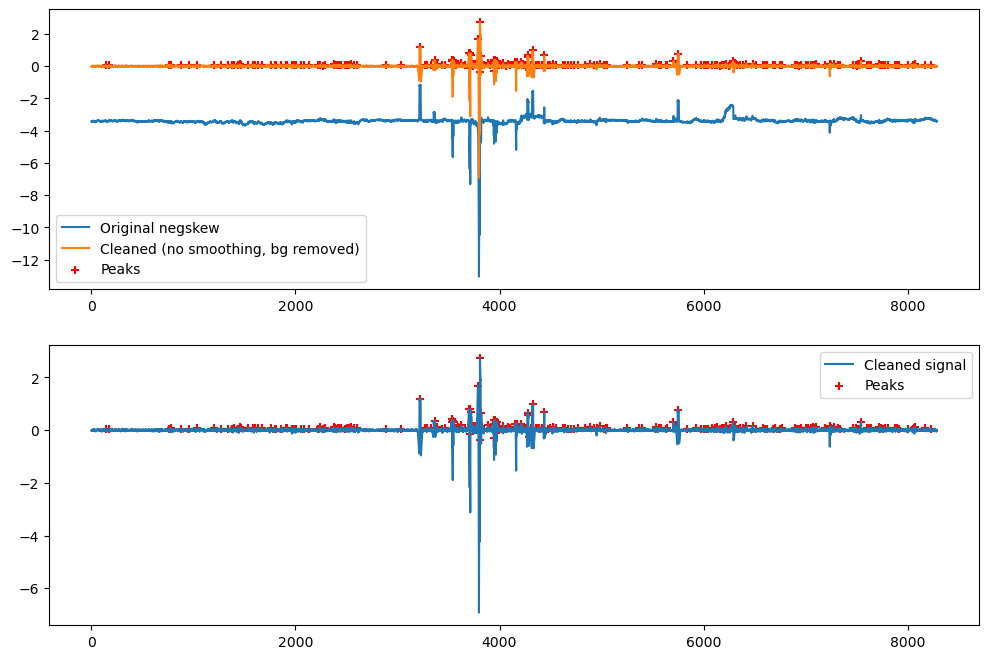

In [20]:
def plot_results(samples):
    for w in samples:
        df = w.data
        signal = df['negskew']
        signal_clean = df['negskew_clean']
        peaks, _ = find_peaks(
            signal_clean, 
            distance=4, 
            prominence=0.1
        )
        
        f, ax = plt.subplots(2, 1, figsize=(12, 8))
        ax[0].plot(signal, label='Original negskew')
        ax[0].plot(signal_clean, label='Cleaned (no smoothing, bg removed)')
        ax[0].scatter(peaks, signal_clean[peaks], marker='+', color='red', label='Peaks')
        ax[0].legend()
        
        ax[1].plot(signal_clean, label='Cleaned signal')
        ax[1].scatter(peaks, signal_clean[peaks], marker='+', color='red', label='Peaks')
        ax[1].legend()
        
        plt.show()

# Call the updated functions
smooth_signal_and_detect_peaks(control.samples)
plot_results(control.samples)

## Calculate properties

In [21]:
# calculate extra stuff
ppars = {'sensitivity' : 0.99, 'min_distance' : 4, 'adaptive_window':300, 'min_prominence':0.05}

control.calculate_property('time')
control.calculate_property('locations')
control.calculate_property('velocity', dt=30)
control.calculate_property('smoothed', key='velocity', window=300, aligned = False)
control.calculate_property("reversals_nose",dt =10, angle_threshold = 140, w_smooth = 30, min_duration = 30)
control.calculate_property("reversals", angle_threshold=100, animal_size=300)

/gpfs/soma_fs/home/ramahefarivo/usr/miniconda3/envs/pumping2/lib/python3.9/site-packages/pg_analysis-0.1-py3.9.egg/pg_analysis/plotter.py:496: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


In [22]:
control.units['negskew'] = 'a.f.u.'  
pumpkey = 'negskew'

# Parameters for feature extraction
ppars = {
    'sensitivity': 0.99,
    'min_distance': 4,
    'adaptive_window': 300,
    'min_prominence': 0.05,
    'use_pyampd': True
}

# Preprocess the negskew signal
control.calculate_property("preprocess_signal", key=pumpkey, w_outlier=None, w_bg=30, w_smooth=1)

# Detect pumps using the cleaned negskew signal
control.calculate_property("pumps", key=f'{pumpkey}_clean', **ppars)

# Calculate count rate (e.g., pump events per unit time)
control.calculate_property("count_rate", window=30, min_periods=30)

# Smooth the count rate to reduce noise
control.calculate_property("smoothed", key="count_rate_pump_events", window=150)

/gpfs/soma_fs/home/ramahefarivo/usr/miniconda3/envs/pumping2/lib/python3.9/site-packages/pg_analysis-0.1-py3.9.egg/pg_analysis/tools.py:65: PeakPropertyWarning: some peaks have a prominence of 0
  prom,_,_  = peak_prominences(signal, peaks, wlen)


## Plots exemples

### Reversals

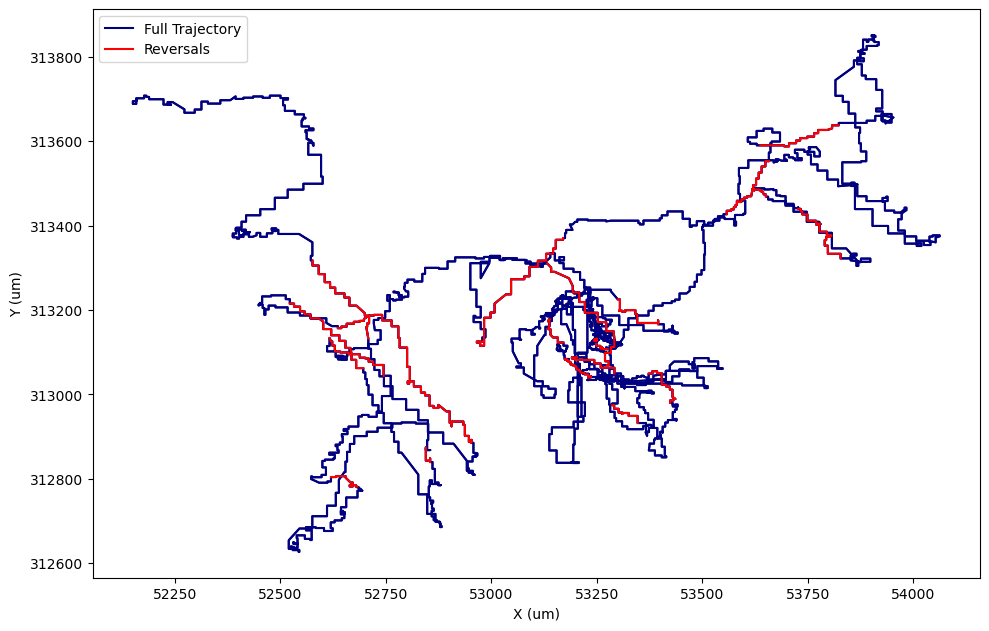

In [23]:
# Extract the single recording
ex = control[:1]  

# Time offset for plotting (e.g., start at 5 minutes)
offset = 5 * 30 * 60  # 5 minutes in frames (30 fps)

reversals = ex.get_sample_metric('reversals_nose')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect(1)
plot, x1, y1 = ex.plot(ax, ('x_scaled', 'y_scaled'), metric=None, color='navy', label='', zorder=-5)
x1_masked = np.ma.masked_where(reversals.values == 0, x1)
y1_masked = np.ma.masked_where(reversals.values == 0, y1)
ax.plot(x1, y1, color='navy', label='Full Trajectory')
ax.plot(x1_masked, y1_masked, color='red', label='Reversals')

xmax = ax.get_xlim()[1]
ymin = ax.get_ylim()[0]

# Add labels and legend
ax.set_xlabel("X (um)")
ax.set_ylabel("Y (um)")
ax.legend()

# Adjust layout and display plot
plt.tight_layout()
plt.show()

### Velocity 

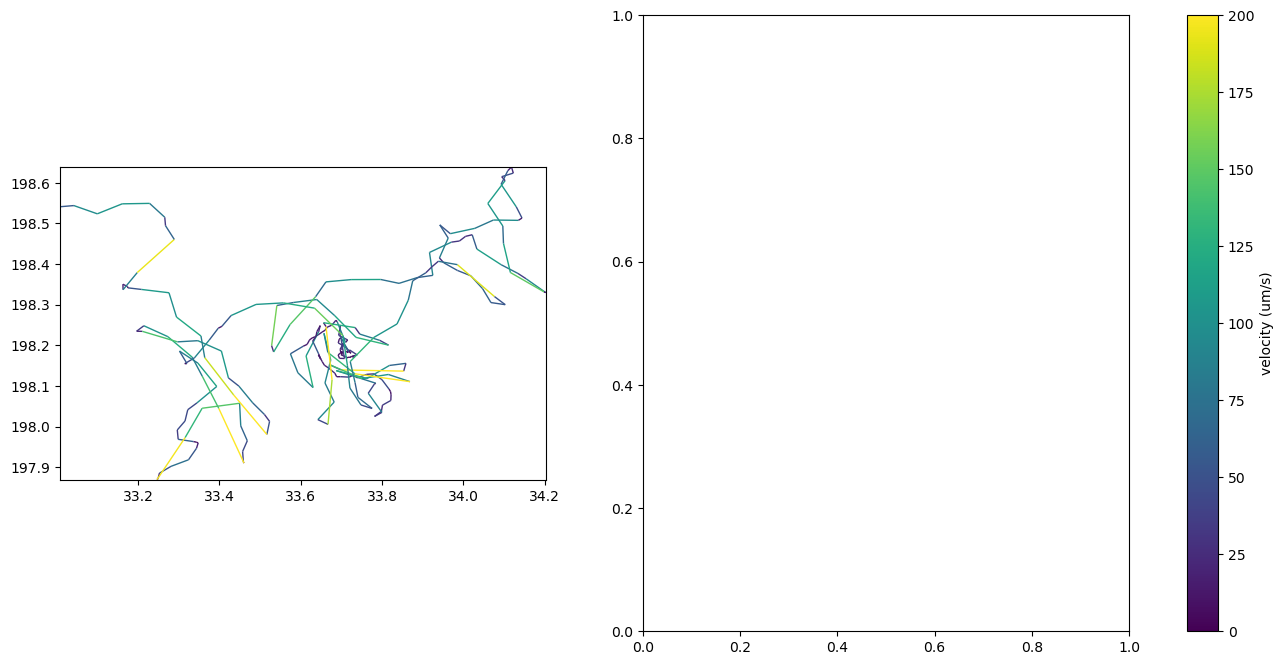

In [24]:
examples = control

fig, axes = plt.subplots(1,2, figsize=(15,8))
axes = axes.ravel()
vmax = 200
n = 30*5
for loc, worm in enumerate(control.samples[:20]):
    axes[loc].set_title(worm.experiment, fontsize=8)
    style.multicolor(axes[loc],worm.data.x[::30]/1000, worm.data.y[::30]/1000,None,t=worm.data.velocity[::30], c=plt.cm.viridis, 
                     threedim = False, etho = False, cg = 1, vmin = 0, vmax = vmax)
    axes[loc].set_aspect(1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=vmax))
plt.colorbar(ax = axes,mappable = sm, label = 'velocity (um/s)', fraction =0.03)

### Density plot 

0.02353367125271543 1.0


[Text(1, 0.0, '0'), Text(1, 0.015, '> 0.015')]

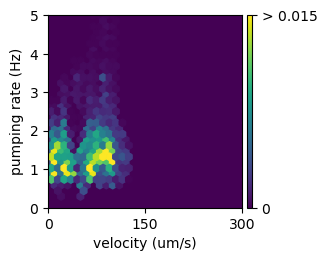

In [25]:
fig, axes = plt.subplots(1,1, figsize=(2.5,2.5))
loc = 0
axes = [axes]
vmax = 0.015
cm = plt.cm.viridis


x = control.get_sample_metric('velocity_smoothed', metric = 'collapse', axis=0)
y = control.get_sample_metric('rate', metric = 'collapse', axis=0)
tmp = pd.concat([x, y], axis=1)
tmp = tmp.dropna()

hb = axes[loc].hexbin(tmp.iloc[:,0], tmp.iloc[:,1], extent = [0,300,0,5], gridsize=30)
hb = axes[loc].hexbin(tmp.iloc[:,0], tmp.iloc[:,1], C=np.ones(len(tmp), dtype=float)/hb.get_array().sum(), 
                      extent = [0,300,0,5], gridsize=30, cmap=cm, reduce_C_function=np.sum, vmax = vmax, vmin =0)
print(hb.get_array()[20:-20].max(), hb.get_array().sum())

ax = axes[-1]
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(hb, cax=cax, ticks=[0,  vmax]) # Similar to fig.colorbar(im, cax = cax)

plt.setp(axes[::2],  ylabel='pumping rate (Hz)');
plt.setp(axes[-2:], xlabel='velocity (um/s)');
plt.setp(axes,xlim=(0,300), ylim=(0,5), yticks=[0,1,2,3,4,5], xticks=[0,150,300]);
#fig.colorbar(cbar, ticks=[0,  vmax])
cbar.ax.set_yticklabels(['0',  f'> {vmax}'])  # vertically oriented colorbar